<a href="https://colab.research.google.com/github/m-riddle-codes/ARA/blob/main/CHEMBL4092122DiffDock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

v3:
- fix py3dmol incompatibility
- downgrade pytorch since the colab version takes forever to install pytorch_geometric (no binary so it has to compile)
THIS MEANS YOU HAVE TO RUN ALL TWICE!

v4:
- replace smina with the more accurate gnina
- remove the annoying run twice thing now there is a binary

v5:
- add ProLIF fingerprint

colab by [@btnaughton](https://twitter.com/btnaughton)

In [ ]:
#@title PDB + SMILES input

PDB_id = '4ZQK' #@param {type:"string"}
SMILES_or_pubchem_id = 'Cc1c(CO)cccc1-c1ccccc1' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

In [ ]:
#import os
#import torch

#if torch.__version__[:6] != "1.13.1":
    #!pip uninstall torch torchaudio torchdata torchtext torchvision fastai -y
    #!pip install torch==1.13.1
    #os.kill(os.getpid(), 9)


In [ ]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

In [ ]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

In [ ]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

## Install prerequisites

In [ ]:
!pip install ipython-autotime --quiet
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00
time: 368 µs (started: 2023-10-07 11:30:50 +00:00)


In [ ]:
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

/content
Cloning into 'DiffDock'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 305 (delta 127), reused 104 (delta 104), pack-reused 147
Receiving objects: 100% (305/305), 232.37 MiB | 20.68 MiB/s, done.
Resolving deltas: 100% (156/156), done.
/content/DiffDock
Note: switching to 'a6c5275'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at a6c5275 remove debugging raise in the inference file
time: 13.9 s (st

In [ ]:
try:
    import biopandas
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.8.0 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet
    # not diffdock-specific:
    !pip install prolif --quiet # no real version??
    !pip install py3dmol==2.0.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
print(torch.__version__)

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # @ 15573f4674b2a37b1b9adc967df69ef6eee573ea

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
time: 33.5 s (started: 2023-10-07 11:32:35 +00:00)


## Install ESM and prepare PDB file for ESM

In [ ]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

/content/DiffDock
Cloning into 'esm'...
remote: Enumerating objects: 1511, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1511 (delta 42), reused 127 (delta 36), pack-reused 1360
Receiving objects: 100% (1511/1511), 11.26 MiB | 18.16 MiB/s, done.
Resolving deltas: 100% (896/896), done.
/content/DiffDock/esm
Note: switching to 'ca8a710'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ca8a710 Update version.py (#310)
Obtaining file:///conten

In [ ]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

/content/DiffDock
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3800.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3810.
  warnings.warn(
100% 1/1 [00:00<00:00, 25.15it/s]
time: 709 ms (started: 2023-10-07 11:33:28 +00:00)


In [ ]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
Transferred model to GPU
Read data/prepared_for_esm.fasta with 2 sequences
Processing 1 of 1 batches (2 sequences)
time: 1min 54s (started: 2023-10-07 11:33:32 +00:00)


## Run DiffDock

In [ ]:
%cd /content/DiffDock
!python -m inference --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 20 --samples_per_complex 40 --batch_size 6

/content/DiffDock
100% 201/201 [01:34<00:00,  2.14it/s]
100% 201/201 [01:53<00:00,  1.77it/s]
/content/DiffDock/utils/torus.py:38: RuntimeWarning: invalid value encountered in divide
  score_ = grad(x, sigma[:, None], N=100) / p_
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00, 47.19it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
loading complexes: 100% 1/1 [00:00<00:00,  3.27it/s]
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings640629660/heterographs.pkl
Number of complexes:  1
radius protein: mean 32.4874153137207, std 0.0, max 32.4874153137207
radius molecule: mean 4.662044048309326, std 0.0, max 4.662044048309326
distance protein-mol: mean 119.57666015625, std 0.0, max 119.57666015625
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not existing) the data f

# Post-process and download results

In [ ]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina
!wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina -O gnina && chmod +x gnina

/content/DiffDock
--2023-10-07 11:47:41--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.37.111, 172.64.150.145, 2606:4700:4400::ac40:9691, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.37.111|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlIUVd2pYvhBTgK8p42Im6hJkoPlSXMNdy6WSscDc4wqbrFKUSUdkYLQS8tJ4ER8O_XDbCibn_84y0rVFF2P6333GPjw%3D%3D&use_mirror=nchc&r= [following]
--2023-10-07 11:47:42--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlIUVd2pYvhBTgK8p42Im6hJkoPlSXMNdy6WSscDc4wqbrFKUSUdkYLQS8tJ4ER8O_XDbCibn_84y0rVFF2P6333GPjw%3D%3D&use_mirror=nchc&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302

## Run gnina to estimate affinity

In [ ]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/gnina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/gnina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "gnina_scored_affinity", "gnina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

/content/DiffDock/results/user_predictions_small


runs:   0%|          | 0/1 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

time: 54.2 s (started: 2023-10-07 11:48:38 +00:00)


### Top hit by DiffDock confidence for any PDB/smiles combination

In [ ]:
top_hit = df_results.sort_values("diffdock_confidence", ascending=False).iloc[0]
df_results.sort_values("diffdock_confidence", ascending=False).head(40)

,pdb_file,smiles,diffdock_confidence,gnina_scored_affinity,gnina_minimized_affinity,sdf_file
36,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-3.99,137.75317,47.79179,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
3,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.15,165.51422,45.79213,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
13,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.29,171.73615,46.18179,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
20,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.33,167.31607,27.33763,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
11,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.34,122.96641,39.45453,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
33,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.35,149.32930,38.42645,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
19,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.43,161.56300,44.85035,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
21,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.44,172.60692,22.58739,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
0,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.57,161.30672,44.57468,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...
4,4ZQK.pdb,Cc1c(CO)cccc1-c1ccccc1,-4.61,158.44800,36.62374,./index0_-tmp-pdb-4ZQK.pdb____Cc1c(CO)cccc1-c1...


time: 17.2 ms (started: 2023-10-07 11:52:54 +00:00)


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['diffdock_confidence'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['gnina_scored_affinity'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['gnina_minimized_affinity'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['diffdock_confidence'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['gnina_scored_affinity'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['gnina_minimized_affinity'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_6, *[[['diffdock_confidence', 'gnina_scored_affinity'], ['gnina_scored_affinity', 'gnina_minimized_affinity']]], **{})
chart

## Show prolif fingerprint

In [ ]:
import prolif as plf
from prolif.plotting.network import LigNetwork
from rdkit import Chem


time: 577 µs (started: 2023-10-07 11:54:59 +00:00)


In [ ]:
try:  # Added the try statement here
    # load protein
    prot = Chem.MolFromPDBFile(pdb_file, removeHs=False)
    prot = plf.Molecule(prot)

    # load ligands
    lig_suppl = list(plf.sdf_supplier(top_hit.sdf_file))

    # generate fingerprint
    fp = plf.Fingerprint()
    fp.run_from_iterable(lig_suppl, prot)

    df_prolif = fp.to_dataframe()
    display(df_prolif)

    prolif_fingerprint_html = "prolif_fingerprint.html"
    net = LigNetwork.from_fingerprint(df_prolif, lig_suppl[0], kind="frame", frame=0, rotation=270)
    net.save(prolif_fingerprint_html)
    net.display()

except Exception as e:  # This is correctly indented now
    print(e)

  0%|          | 0/1 [00:00<?, ?it/s]

ligand            UNL1                                                \
protein       ALA121.A    TYR123.A                VAL64.B              
interaction VdWContact Hydrophobic VdWContact Hydrophobic VdWContact   
Frame                                                                  
0                 True        True       True        True       True   

ligand                                                               \
protein        ASN66.B     TYR68.B              GLY124.B   ALA125.B   
interaction VdWContact Hydrophobic VdWContact VdWContact VdWContact   
Frame                                                                 
0                 True        True       True       True       True   

ligand                                                               
protein        ILE126.B              ILE134.B   GLU136.B   HOH203.B  
interaction Hydrophobic VdWContact VdWContact VdWContact VdWContact  
Frame                                                                
0                  True       True       True       True       True

Please run the fingerprint analysis before attempting to display results.
time: 240 ms (started: 2023-10-07 11:55:09 +00:00)


## Create dataframe, tar file and download

In [ ]:
out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv} {prolif_fingerprint_html}

    files.download(f"{tarname}.tar")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 115 ms (started: 2023-10-07 11:50:48 +00:00)


## Compare gnina affinities with DiffDock confidences

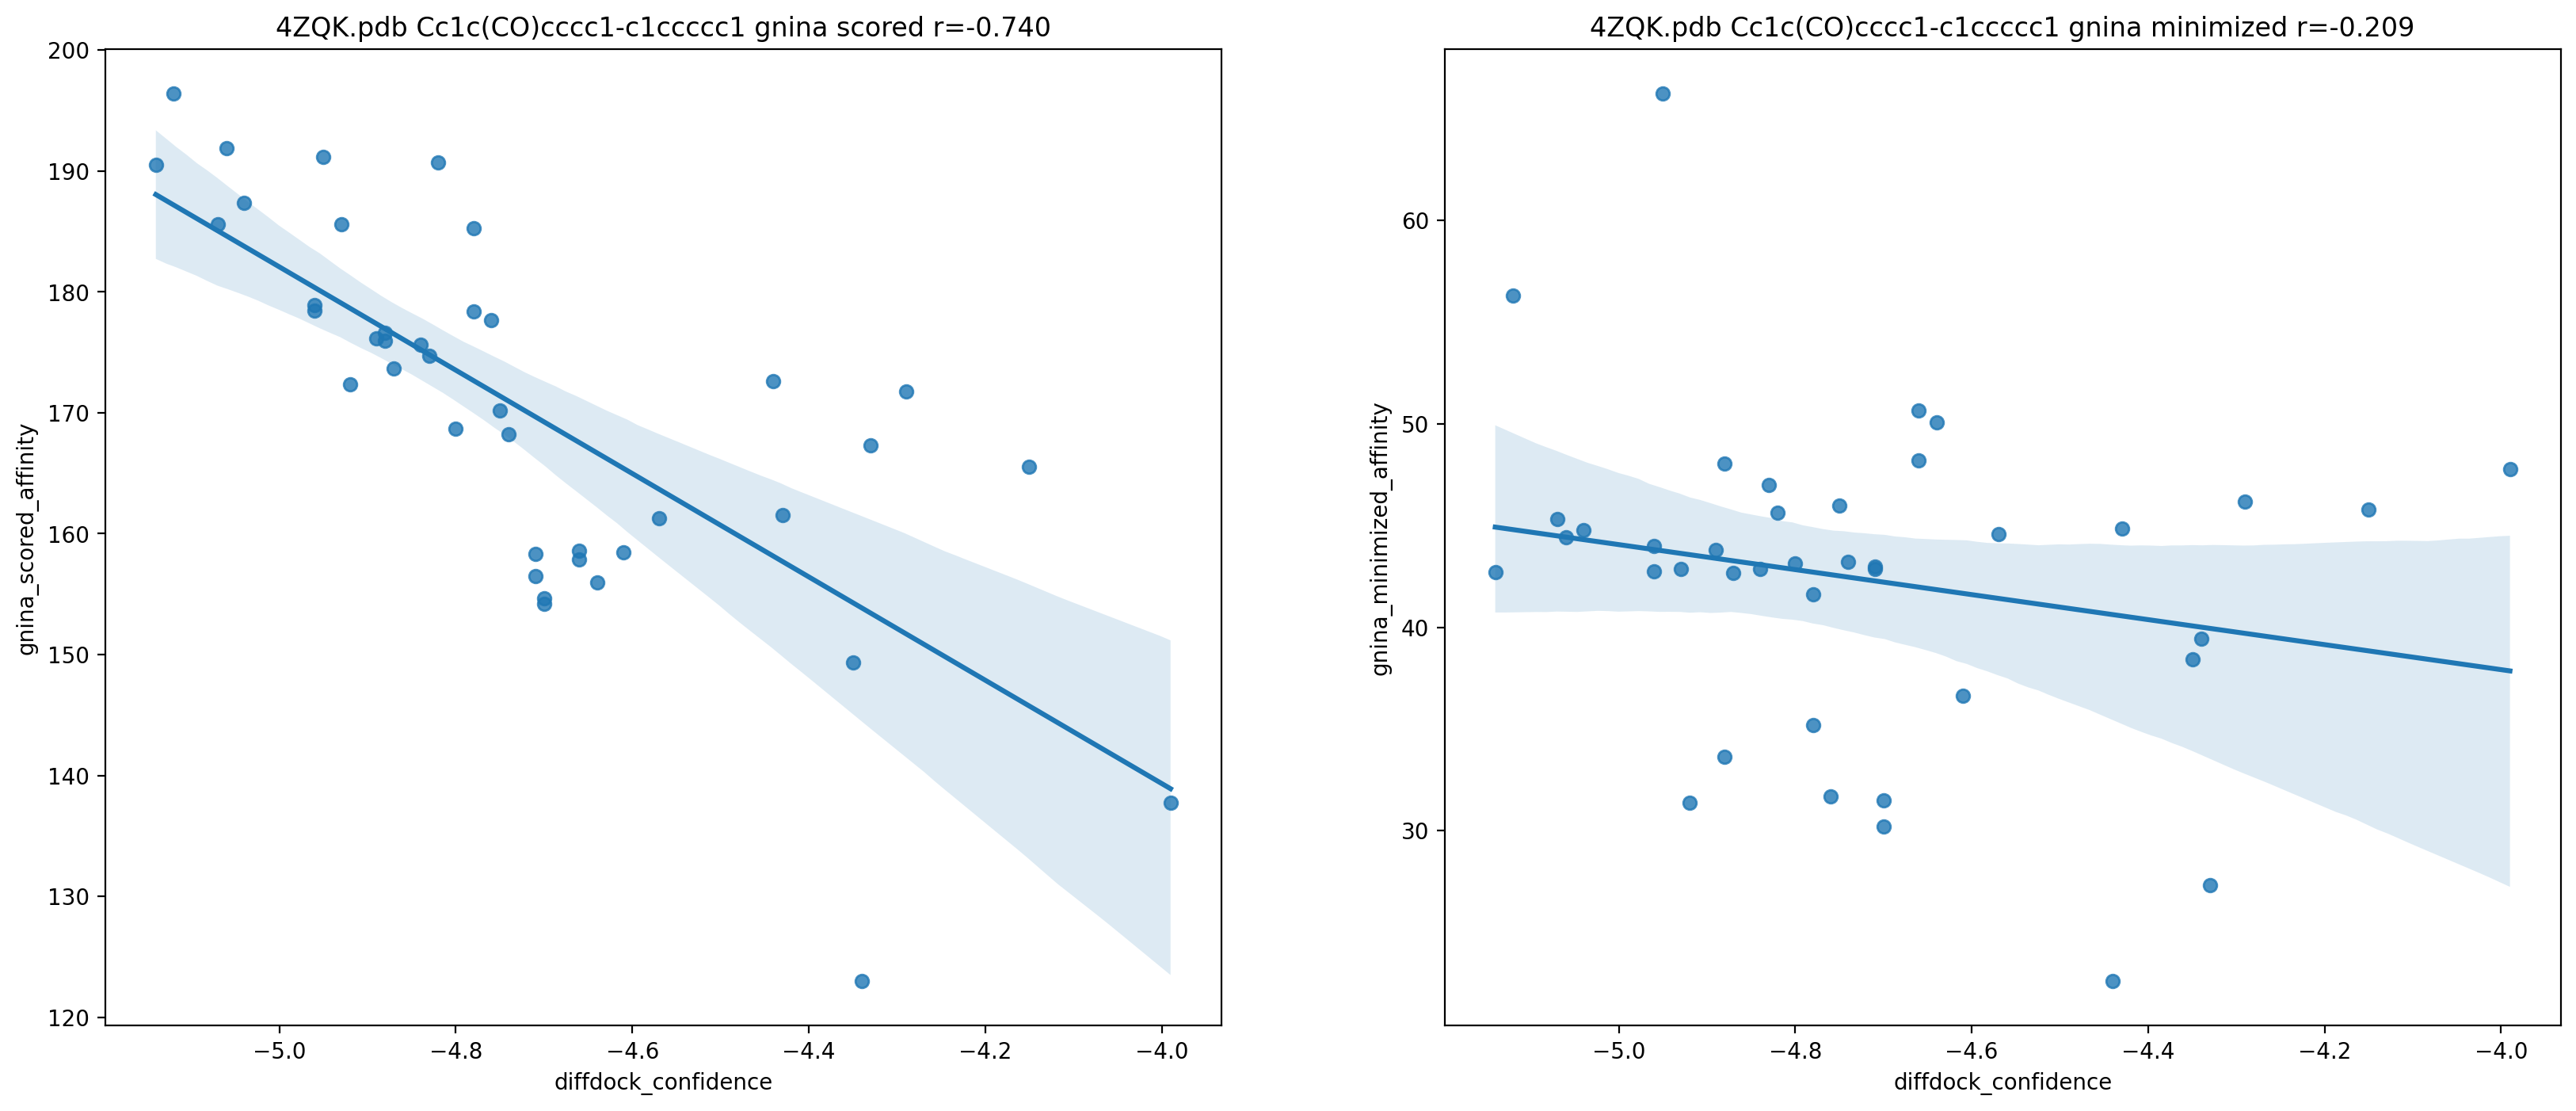

time: 1.15 s (started: 2023-10-07 11:51:11 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} gnina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} gnina minimized r={r_value_minimized:.3f}");

# Visualize top hit (highest confidence) in 3D

In [ ]:
from IPython.display import HTML
import py3Dmol

resid_hover = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.chain+" "+atom.resn+" "+atom.resi,
            {position: atom, backgroundColor: 'mintcream', fontColor:'black', fontSize:12});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

view = py3Dmol.view(width=800, height=800)
view.setCameraParameters({'fov': 35, 'z': 100});


# add sdf
view.addModel(open(top_hit.sdf_file).read(), "sdf")
view.setStyle({"model": 0}, {'stick':{"color":"#ff0000"}})
view.setViewStyle({"model": 0}, {'style':'outline','color':'black','width':0.1})
view.zoomTo();

# add pdb
view.addModel(open(top_hit.pdb_file).read(), "pdb");
view.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})

model = view.getModel()
model.setHoverable({}, True, resid_hover, unhover_func)

view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

time: 24.2 ms (started: 2023-10-07 11:51:20 +00:00)
